In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import urllib3
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import imgaug.augmenters as iaa

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

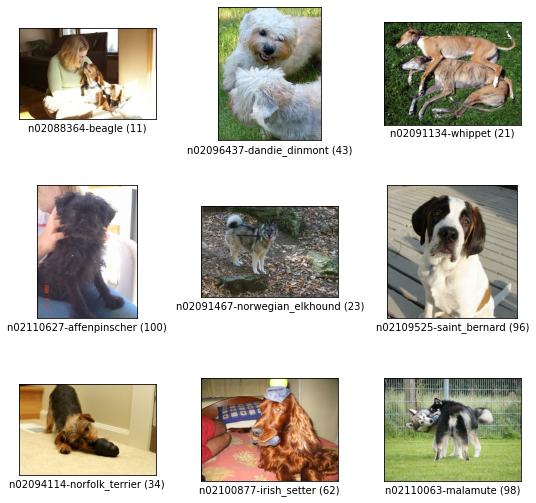

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

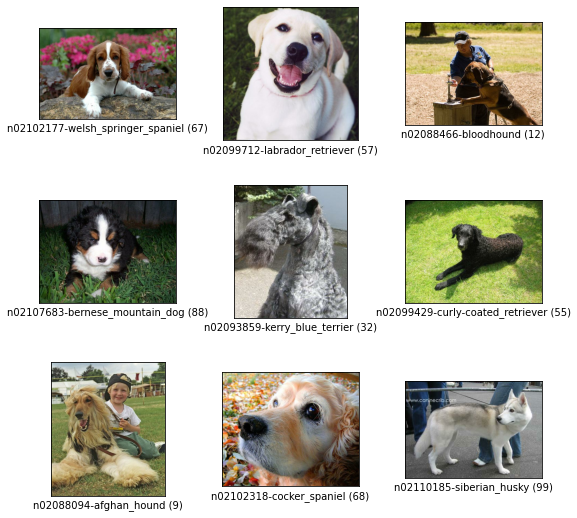

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

## Augmentation함수 정의하기

### 기본 Augmentation

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

### Cutmix Augmentation

In [10]:
def get_clip_box(image_a, image_b, img_size=224):
    # 박스의 위치를 이동시킴
    x = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    y = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    
    # with를 150으로 고정시킴
    width = 120
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [11]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [12]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = 0.3

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [13]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup Augmentation

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    # 알파를 0.2로 고정
    a = 0.5
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [15]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## onehot 함수

In [16]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

## Augmentation을 적용한 데이터셋 만들기

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 모델 만들기

### 기본 Augumentation 적용 모델

In [18]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### imgaug 적용 모델

In [19]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### CutMix 적용 모델

In [20]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### Mixup 적용 모델

In [21]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [24]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_no = apply_normalize_on_dataset(ds_test, is_test = True)
ds_test_one = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)

In [25]:
print(ds_train_cutmix)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>


## 함수 동작 확인

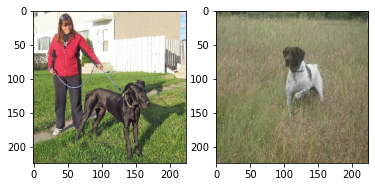

In [28]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

### Mixup 확인

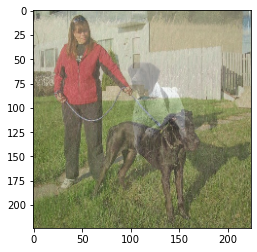

In [82]:
mixed_image, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_image.numpy())

In [183]:
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ], dtype=float32)>

### CutMix 확인

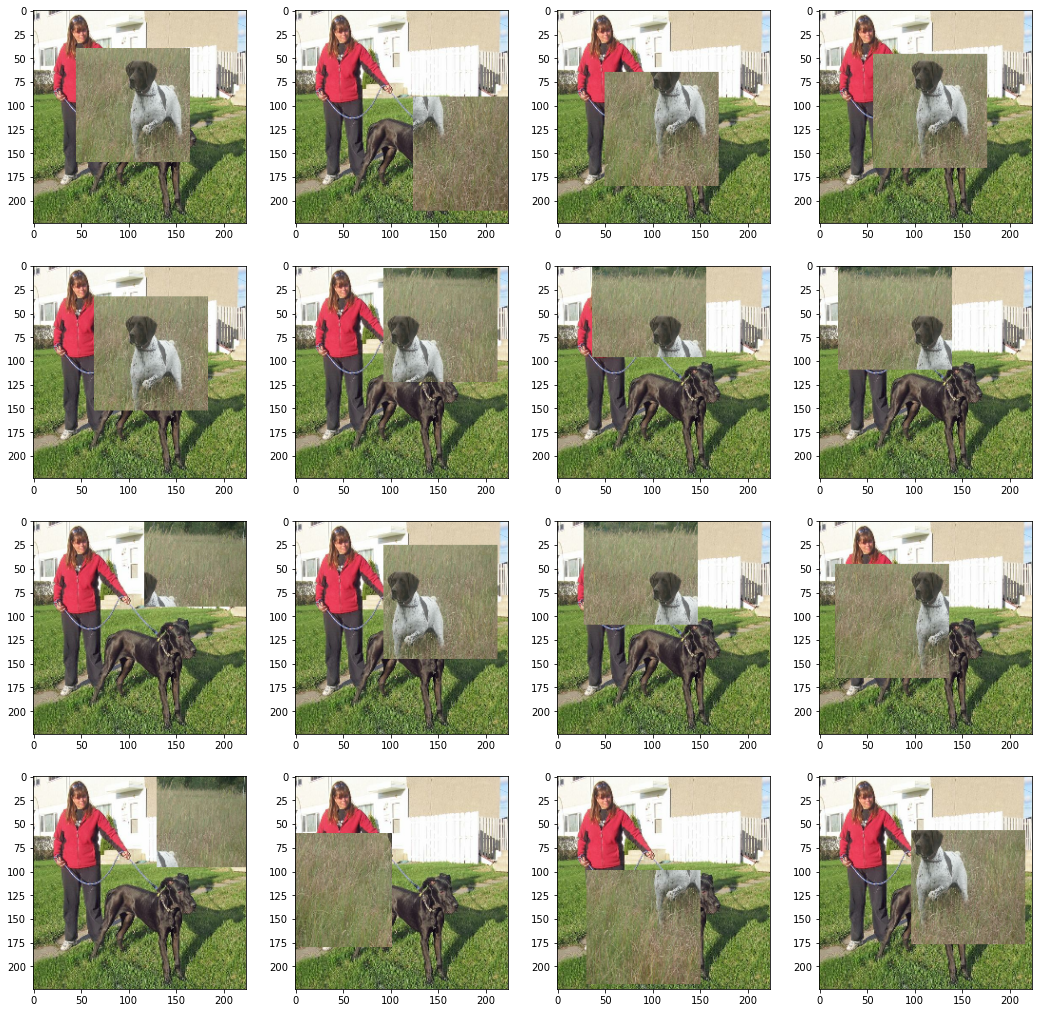

In [55]:
plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4, 4, i+1)
    xa, ya, xb, yb = get_clip_box(image_a, image_b)
    mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
    plt.imshow(mixed_img.numpy())

In [58]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ], dtype=float32)>

## 모델 훈련하기

In [83]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [20]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 117s 155ms/step - loss: 2.1969 - accuracy: 0.4477 - val_loss: 3.8463 - val_accuracy: 0.1538
Epoch 2/15
750/750 [==============================] - 113s 151ms/step - loss: 0.7878 - accuracy: 0.7822 - val_loss: 1.2603 - val_accuracy: 0.6370
Epoch 3/15
750/750 [==============================] - 114s 153ms/step - loss: 0.3081 - accuracy: 0.9272 - val_loss: 1.0350 - val_accuracy: 0.7014
Epoch 4/15
750/750 [==============================] - 115s 153ms/step - loss: 0.1137 - accuracy: 0.9830 - val_loss: 0.9299 - val_accuracy: 0.7281
Epoch 5/15
750/750 [==============================] - 115s 153ms/step - loss: 0.0581 - accuracy: 0.9943 - val_loss: 0.9361 - val_accuracy: 0.7341
Epoch 6/15
750/750 [==============================] - 111s 149ms/step - loss: 0.0314 - accuracy: 0.9974 - val_loss: 0.9242 - val_accuracy: 0.7413
Epoch 7/15
750/750 [==============================] - 114s 152ms/step - loss: 0.0169 - accuracy: 0.9991 - val_loss: 0.9175 -

In [64]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 123s 164ms/step - loss: 2.2404 - accuracy: 0.4368 - val_loss: 3.1540 - val_accuracy: 0.2374
Epoch 2/15
750/750 [==============================] - 119s 159ms/step - loss: 0.9547 - accuracy: 0.7233 - val_loss: 1.2753 - val_accuracy: 0.6374
Epoch 3/15
750/750 [==============================] - 120s 160ms/step - loss: 0.5663 - accuracy: 0.8395 - val_loss: 1.1592 - val_accuracy: 0.6651
Epoch 4/15
750/750 [==============================] - 122s 162ms/step - loss: 0.3019 - accuracy: 0.9244 - val_loss: 1.2075 - val_accuracy: 0.6679
Epoch 5/15
750/750 [==============================] - 120s 160ms/step - loss: 0.1733 - accuracy: 0.9610 - val_loss: 1.0379 - val_accuracy: 0.7059
Epoch 6/15
750/750 [==============================] - 123s 163ms/step - loss: 0.1242 - accuracy: 0.9753 - val_loss: 1.0449 - val_accuracy: 0.7100
Epoch 7/15
750/750 [==============================] - 118s 157ms/step - loss: 0.0706 - accuracy: 0.9891 - val_loss: 0.9255 -

In [60]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 129s 172ms/step - loss: 3.9466 - accuracy: 0.1844 - val_loss: 3.3109 - val_accuracy: 0.2126
Epoch 2/15
750/750 [==============================] - 129s 172ms/step - loss: 3.1004 - accuracy: 0.3915 - val_loss: 1.5204 - val_accuracy: 0.5709
Epoch 3/15
750/750 [==============================] - 129s 172ms/step - loss: 2.8144 - accuracy: 0.4672 - val_loss: 1.2932 - val_accuracy: 0.6322
Epoch 4/15
750/750 [==============================] - 122s 163ms/step - loss: 2.5929 - accuracy: 0.5397 - val_loss: 1.5450 - val_accuracy: 0.5730
Epoch 5/15
750/750 [==============================] - 116s 154ms/step - loss: 2.4406 - accuracy: 0.5838 - val_loss: 1.3415 - val_accuracy: 0.6458
Epoch 6/15
750/750 [==============================] - 116s 154ms/step - loss: 2.2985 - accuracy: 0.6273 - val_loss: 1.2982 - val_accuracy: 0.6502
Epoch 7/15
750/750 [==============================] - 116s 154ms/step - loss: 2.2334 - accuracy: 0.6567 - val_loss: 1.0985 -

In [84]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 131s 175ms/step - loss: 3.2367 - accuracy: 0.3137 - val_loss: 1.7146 - val_accuracy: 0.5711
Epoch 2/15
750/750 [==============================] - 131s 175ms/step - loss: 3.0732 - accuracy: 0.3309 - val_loss: 1.4635 - val_accuracy: 0.6154
Epoch 3/15
750/750 [==============================] - 130s 173ms/step - loss: 2.9569 - accuracy: 0.3582 - val_loss: 1.4396 - val_accuracy: 0.6203
Epoch 4/15
750/750 [==============================] - 130s 174ms/step - loss: 2.9087 - accuracy: 0.3527 - val_loss: 1.5152 - val_accuracy: 0.6124
Epoch 5/15
750/750 [==============================] - 130s 173ms/step - loss: 2.8516 - accuracy: 0.3639 - val_loss: 1.5926 - val_accuracy: 0.5914
Epoch 6/15
750/750 [==============================] - 131s 174ms/step - loss: 2.7498 - accuracy: 0.3760 - val_loss: 1.5549 - val_accuracy: 0.5998
Epoch 7/15
750/750 [==============================] - 131s 174ms/step - loss: 2.6667 - accuracy: 0.3929 - val_loss: 1.4690 -

In [71]:
with open('./data/npy/argument.npy', 'wb') as f:
    np.save(f, acc_resnet50_no)
    np.save(f, history_resnet50_aug.history['val_accuracy'])
    np.save(f, history_resnet50_cutmix.history['val_accuracy'])    
    np.save(f, acc_resnet50_mixup)    

In [78]:
with open('./data/npy/alpha.npy', 'wb') as f: 
    np.save(f, acc_resnet50_mixup)    
    np.save(f, history_resnet50_mixup.history['val_accuracy'])    

In [62]:
with open('./data/npy/G4.npy', 'rb') as f:
    acc_resnet50_no = np.load(f)
    acc_resnet50_mixup  = np.load(f)
    acc_resnet50_cutmix = np.load(f)
    acc_resnet50_mixup = np.load(f)

In [85]:
with open('./data/npy/alpha.npy', 'rb') as f:
    mixup_alpha_random = np.load(f)
    mixup_alpha_02  = np.load(f)

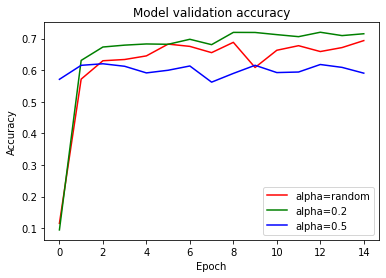

In [87]:
plt.plot(mixup_alpha_random, 'r')
plt.plot(mixup_alpha_02, 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['alpha=random', 'alpha=0.2', 'alpha=0.5'], loc='lower right')
plt.show()

위의 그래프는 mixup 함수에서 alpha값을 조정했을 때의 비교 모습입니다.  
alpha가 random, 0.2, 0.5로 총 3가지의 경우의 수로 테스트를 해봤습니다.  
그 결과 alpha값이 0.2일 때 가장 좋은 성능을 보이는 것을 확인 할 수 있습니다.

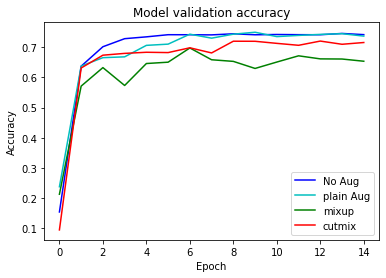

In [75]:
plt.plot(acc_resnet50_no, 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(mixup_alpha_02, 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'plain Aug' , 'mixup', 'cutmix'], loc='lower right')
plt.show()

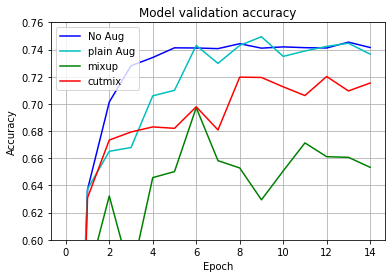

In [88]:
plt.plot(acc_resnet50_no, 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(mixup_alpha_02, 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'plain Aug' , 'mixup', 'cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

## Report

예측한 결과와 다르게 Augmentation을 추가해도 정확도가 개선 되지 않은 모습을 볼 수 있다.  
그 이유를 짐작해보자면, Agumentation을 하는 이유에 있다고 생각한다.  
Augmentation을 하는 이유는 원본 데이터 이외에도 Augmentation을 이용한 변형 이미지를 추가시켜 Overfitting을 개선시키고 성능을 더 좋게 하기 위함이다.  
하지만 이번 프로젝트에서는 원본데이터 + Augmentation데이터가 아닌 변형된 이미지만을 사용했기 때문이다.  
말그대로 '뻥튀기'를 위한 역할을 제대로 수행되지 못했다는 점이다.  
만약 다양한 Augmentation 결과를 원래 데이터에 추가해서 데이터를 부풀렸다면 더 좋은 성능을 기대할 수 있을 것이다.